## Интеллектуальный анализ данных – весна 2023
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html). 

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования.

In [4]:
#удаление пропущенных значений, если таковых нет, просто ничего не поменяется
X.dropna()
#кодирование категориальных переменных, если таковых нет, просто ничего не поменяется
cat_features_mask = (X.dtypes == "object").values
X_dum = pd.get_dummies(X, drop_first=True)
X_dum.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

In [5]:
from sklearn.model_selection import train_test_split
np.random.seed(11)
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.3, random_state=10)

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [7]:
ks = [1, 3, 5, 10, 15, 25]
pretrained = []

X_train_c = X_train[['alcohol', 'magnesium']]
X_test_c = X_test[['alcohol', 'magnesium']]

scaler = StandardScaler()
X_real_norm_np = scaler.fit_transform(X_train_c)
X_train_n = pd.DataFrame(data=X_real_norm_np)

X_test_norm_np = scaler.transform(X_test_c)
X_test_n = pd.DataFrame(data=X_test_norm_np)

for k in ks:
    clf = KNeighborsClassifier(n_neighbors=k, p=2).fit(X_train_c.values, y_train)
    pretrained.append(clf)
    y_predicted_train = clf.predict(X_train_c.values)
    val_accuracy_train = accuracy_score(y_train, y_predicted_train)
    y_predicted_test = clf.predict(X_test_c.values)
    val_accuracy_test = accuracy_score(y_test, y_predicted_test)
    print(f"k = {k}; accuracy_train = {val_accuracy_train:.3f}; accuracy_test = {val_accuracy_test:.3f}")
    

k = 1; accuracy_train = 0.992; accuracy_test = 0.685
k = 3; accuracy_train = 0.710; accuracy_test = 0.685
k = 5; accuracy_train = 0.702; accuracy_test = 0.574
k = 10; accuracy_train = 0.734; accuracy_test = 0.593
k = 15; accuracy_train = 0.613; accuracy_test = 0.556
k = 25; accuracy_train = 0.540; accuracy_test = 0.537


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/). 

In [9]:
!pip install mlxtend

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 1.3 MB/s eta 0:00:0000:0100:010m


Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [8]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов. 
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново. 
6. Построение графика может занять некоторое время – придётся немного подождать!

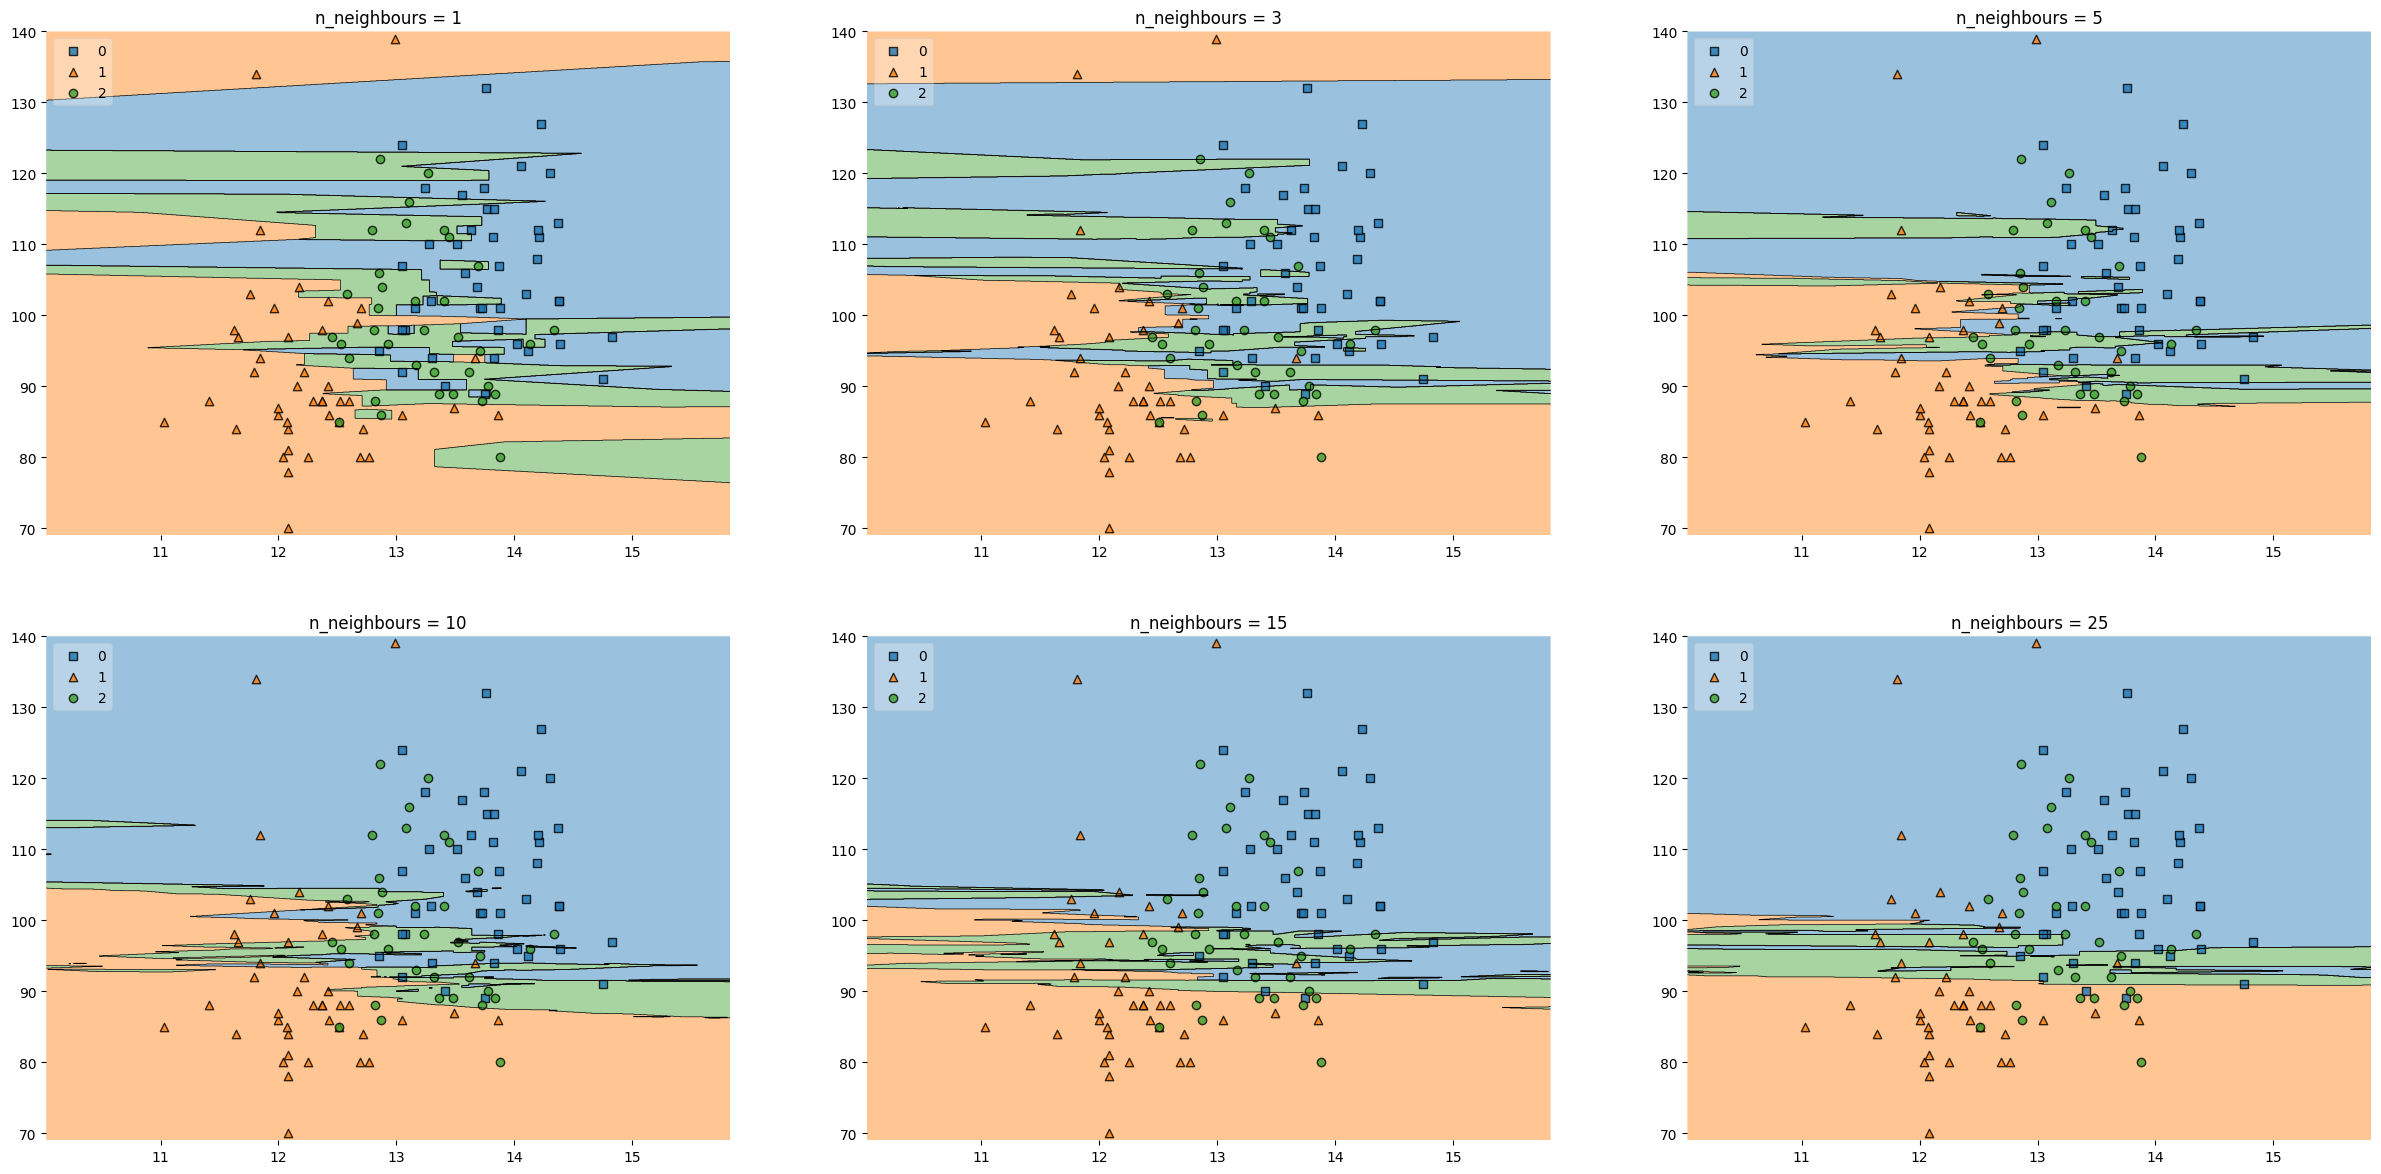

In [9]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(2, 3)
X = X_train_c.values
y = y_train
fig = plt.figure(figsize=(30, 14.4))

labels = ['n_neighbours = 1', 'n_neighbours = 3', 'n_neighbours = 5', 'n_neighbours = 10', 'n_neighbours = 15', 'n_neighbours = 25']
for clf, lab, grd in zip(pretrained, labels, itertools.product([0, 1, -1], repeat=2)):
    
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности.

### Комментарий: 
Мы видим, что чем больше число соседей, тем ниже точность. 
У меня результаты получились такими, что первые 2 значения - самые оптимальные, то есть не везде решающая 
поверхность совпадает с тем, как должны быть распределены данные по классам, и, чем больше значение гиперпараметра, 
тем сильнее различия.
Итог: птимально использовать 1 или 3 соседей. Мы видим, что в таком случае по графику точность достаточно хорошая.

### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

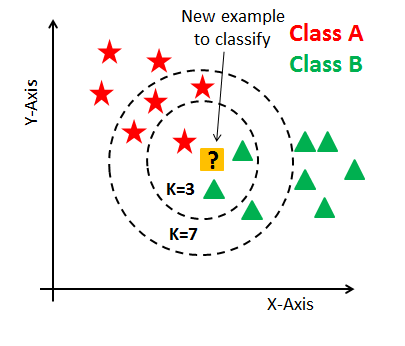

In [16]:
import numpy as np

class KNN:
    def __init__(self, k:int):
        self.k = k
    
    def fit(self, X, y):
        self.X = X
        self.y = y

        pass
    
    def predict(self, X):
        x = self.X
        y_train = self.y
        k = self.k
        #здесь я с помощью евклидовой метрики вычисляю расстояние между объектами тестовой и тренировочной выборки
        #потом сортирую полученные значения, выводя их индексы, оставляю k нужных
        index = np.argsort(((((X[:, np.newaxis, :] - x[np.newaxis, :, :])**2).sum(axis=2))**0.5), axis = -1)[:, :k]
        return np.round((y_train[index].sum(axis=1)/k), 0)
        pass

In [17]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [18]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [19]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.1 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их. 

In [20]:
data.dropna()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...,...
53935,53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


**Задача 3.2 (0.1 балла)** Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [21]:
data.pop('Unnamed: 0')
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Задача 3.3 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [22]:
corr_matrix = data.corrwith(data['price'])
print(corr_matrix)
#больше всего коррелируют carat и x, y, z

carat    0.921591
depth   -0.010647
table    0.127134
price    1.000000
x        0.884435
y        0.865421
z        0.861249
dtype: float64


/tmp/ipykernel_100/1005212881.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corrwith(data['price'])


**Задача 3.4 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [23]:
cat_features_mask = (data.dtypes == "object").values
data = pd.get_dummies(data, drop_first=True)
data.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0


**Задача 3.5 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [24]:
np.random.seed(11)

y = data['price']
data.pop('price')

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=10)

**Задача 3.6 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [25]:
scaler = StandardScaler()
X_real_norm_np = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data=X_real_norm_np)

X_test_norm_np = scaler.transform(X_test)
X_test = pd.DataFrame(data=X_test_norm_np)

**Задача 3.7 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train, y_train)
print(f"Train MSE: {mean_squared_error(y_train, lr.predict(X_train))}")
print(f"Test MSE: {mean_squared_error(y_test, lr.predict(X_test))}")

Train MSE: 1268454.9559615587
Test MSE: 1303126.7488467365


**Задача 3.8 (0.2 балла)** Изучите документацию модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [27]:
df = pd.DataFrame({'Params': list(data.columns), 'Coefs': list(np.absolute(lr.coef_))})
print(df)
#На порядок выше превышают оценки прочих вещественных переменных параметры carat, clarity_SI1, clarity_VS1, clarity_VS2, clarity_VVS2

           Params        Coefs
0           carat  5268.334845
1           depth    73.111300
2           table    67.588760
3               x   959.001979
4               y    80.663235
5               z   238.038613
6        cut_Good   180.155737
7       cut_Ideal   421.771664
8     cut_Premium   345.464522
9   cut_Very Good   319.333157
10        color_E    78.915265
11        color_F   102.443444
12        color_G   190.841862
13        color_H   349.279490
14        color_I   431.944388
15        color_J   513.635437
16     clarity_IF   965.635625
17    clarity_SI1  1586.680923
18    clarity_SI2  1032.551108
19    clarity_VS1  1651.298292
20    clarity_VS2  1808.177050
21   clarity_VVS1  1274.415267
22   clarity_VVS2  1453.375295


**Задача 3.9 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом. 

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией. 

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [30]:
from sklearn.linear_model import Lasso, Ridge

lasso = Lasso(10.0).fit(X_train, y_train)
print("Lasso")
print(f"Train: {mean_squared_error(y_train, lasso.predict(X_train))}")
print(f"Test: {mean_squared_error(y_test, lasso.predict(X_test))}")
print(pd.DataFrame({'Params': list(data.columns), 'LassoCoefs': list(np.absolute(lasso.coef_))}))

ridge = Ridge(10.0).fit(X_train, y_train)
print("\nRidge")
print(f"Train: {mean_squared_error(y_train, ridge.predict(X_train))}")
print(f"Test: {mean_squared_error(y_test, ridge.predict(X_test))}")
print(pd.DataFrame({'Params': list(data.columns), 'RidgeCoefs': list(np.absolute(ridge.coef_))}))

'''В случае с Lasso-регрессией веса уменьшились сильнее, чем в случае с Ridge-регрессией. 
Особенно по Lasso-регрессии видно, что в изначальной регрессии проблема была заметной: 
значения некоторых коэффициентов снизились на несколько сотен.'''

Lasso
Train: 1330335.8661404853
Test: 1367367.040854752
           Params   LassoCoefs
0           carat  4789.301380
1           depth    86.418657
2           table    76.384212
3               x   488.898100
4               y     0.000000
5               z   194.282630
6        cut_Good    55.057846
7       cut_Ideal   216.790822
8     cut_Premium   157.065492
9   cut_Very Good   149.175622
10        color_E     7.884083
11        color_F    36.147716
12        color_G   112.156115
13        color_H   275.572789
14        color_I   360.543701
15        color_J   453.057340
16     clarity_IF   633.623805
17    clarity_SI1   816.235915
18    clarity_SI2   363.210391
19    clarity_VS1  1001.187379
20    clarity_VS2  1053.316578
21   clarity_VVS1   815.196499
22   clarity_VVS2   924.700207

Ridge
Train: 1268581.4112912423
Test: 1303825.3625688276
           Params   RidgeCoefs
0           carat  5231.924260
1           depth    70.737168
2           table    67.727091
3               x 

'В случае с Lasso-регрессией веса уменьшились сильнее, чем в случае с Ridge-регрессией. \nОсобенно по Lasso-регрессии видно, что в изначальной регрессии проблема была заметной: \nзначения некоторых коэффициентов снизились на несколько сотен.'

**Задача 3.10 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов. 

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

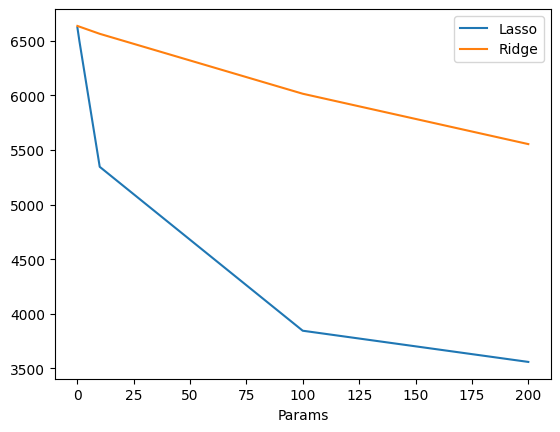

'Агрессивнее уменьшает веса метод Lasso. \nLasso часто используют, потому что она хорошо зануляет большие коэффициенты и сильнее уменьшает их в целом'

In [34]:
import matplotlib.pyplot as plt

p_r = [0.1, 1, 10, 100, 200]
p_vec_l = []
p_vec_r = []
for i in p_r:
    lasso = Lasso(i).fit(X_train, y_train)
    p_vec_l.append(np.linalg.norm(lasso.coef_))
    ridge = Ridge(i).fit(X_train, y_train)
    p_vec_r.append(np.linalg.norm(ridge.coef_))
df = pd.DataFrame({'Params': p_r, 'Lasso': p_vec_l, 'Ridge': p_vec_r})

df.plot(x="Params", y=["Lasso", "Ridge"])
plt.show()

'''Агрессивнее уменьшает веса метод Lasso. 
Lasso часто используют, потому что она хорошо зануляет большие коэффициенты и сильнее уменьшает их в целом'''
    

**Задача 3.11 (0.5 балла)** 
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке. 

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`. 

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество. 

In [32]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(alphas=[0.1, 1, 10, 100, 200], cv=5).fit(X_train, y_train)
#вывожу значение, дающее наибольшее качество
print(list(lasso_cv.alphas_)[np.argmin(lasso_cv.mse_path_.mean(axis=1))])

/home/arinkazam/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1093147008.0473938, tolerance: 47234925.03802861
  model = cd_fast.enet_coordinate_descent_gram(


0.1


**Задача 3.12 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [33]:
lasso = Lasso(0.1).fit(X_train, y_train)
print(pd.DataFrame({'Params': list(data.columns), 'LassoCoefs': list(np.absolute(lasso.coef_))}))

'''Наиболее информативны признаки carat, что неудивительно, поскольку этот признак действительно влияет на цену бриллиантов 
(чем больше, тем дороже), также влияет признак clarity (чистота бриллианта), опять же это соответствует реальности, 
на цену бриллианта влияет то, насколько эстетично он выглядит.'''

           Params   LassoCoefs
0           carat  5263.753948
1           depth    73.603751
2           table    67.717120
3               x   947.121177
4               y    69.981030
5               z   235.136443
6        cut_Good   179.059467
7       cut_Ideal   419.933698
8     cut_Premium   343.644706
9   cut_Very Good   317.884560
10        color_E    78.189773
11        color_F   101.771765
12        color_G   190.052420
13        color_H   348.546969
14        color_I   431.229146
15        color_J   513.028159
16     clarity_IF   962.368991
17    clarity_SI1  1579.084851
18    clarity_SI2  1025.942199
19    clarity_VS1  1644.906570
20    clarity_VS2  1800.732096
21   clarity_VVS1  1269.887971
22   clarity_VVS2  1448.166714


'Наиболее информативны признаки carat, что неудивительно, поскольку этот признак действительно влияет на цену бриллиантов \n(чем больше, тем дороже), также влияет признак clarity (чистота бриллианта), опять же это соответствует реальности, \nна цену бриллианта влияет то, насколько эстетично он выглядит.'

**Задача 3.13 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [35]:
print(f"Test Lasso: {mean_squared_error(y_test, lasso.predict(X_test))}")
print(f"Test lr: {mean_squared_error(y_test, lr.predict(X_test))}")
'''Lasso лучше использовать. Она такой оказалась, потому что в ней есть штраф за большие веса, 
устраняются проблемы, появляющиеся из-за мультиколлинеарности '''

Test Lasso: 2219107.5867127664
Test lr: 1303126.7488467365


'Lasso лучше использовать. Она такой оказалась, потому что в ней есть штраф за большие веса, \nустраняются проблемы, появляющиеся из-за мультиколлинеарности '